## Tratamento da Base de dados
Extração • Transformação • Limpeza • Normalização • Exportação

Nesta primeira parte do projeto realizamos todo o processo de ETL (Extract, Transform, Load) da base Olist, que foi divididas em etapas.
O objetivo é transformar as múltiplas tabelas do banco SQLite em um único arquivo CSV tratado e pronto para análise, que será utilizado posteriormente na Parte B (Visualização e Gráficos).

### 1º Etapa: Importar bibliotecas e conectar ao banco

In [1]:
import pandas as pd
import sqlite3

DB_PATH = "data/olist.sqlite"

conn = sqlite3.connect(DB_PATH)

orders = pd.read_sql("SELECT * FROM orders", conn)
order_items = pd.read_sql("SELECT * FROM order_items", conn)
products = pd.read_sql("SELECT * FROM products", conn)
customers = pd.read_sql("SELECT * FROM customers", conn)
sellers = pd.read_sql("SELECT * FROM sellers", conn)
payments = pd.read_sql("SELECT * FROM order_payments", conn)
reviews = pd.read_sql("SELECT * FROM order_reviews", conn)


### 2º Etapa: Limpeza dos dados

In [3]:
orders = orders.drop_duplicates()
order_items = order_items.drop_duplicates()
products = products.drop_duplicates()
customers = customers.drop_duplicates()
sellers = sellers.drop_duplicates()
payments = payments.drop_duplicates()
reviews = reviews.drop_duplicates()

orders["order_delivered_customer_date"] = pd.to_datetime(
    orders["order_delivered_customer_date"], errors="coerce"
)

orders["order_delivered_customer_date"] = orders[
    "order_delivered_customer_date"
].fillna(pd.NaT)

print("Valores nulos em orders:\n", orders.isna().sum())
print("Valores nulos em payments:\n", payments.isna().sum())

Valores nulos em orders:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Valores nulos em payments:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64


### 3º Etapa: Normalização de colunas

In [4]:
if "product_category_name" in products.columns:
    products["product_category_name"] = (
        products["product_category_name"]
        .str.lower()
        .str.strip()
    )

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in date_cols:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors="coerce")

### 4º Etapa: Criar métricas

In [5]:
orders["tempo_entrega_dias"] = (
    orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
).dt.days

order_count = (
    order_items.groupby("order_id")
    .size()
    .reset_index(name="compras_por_pedido")
)

orders = orders.merge(order_count, on="order_id", how="left")

orders["order_id"] = orders["order_id"].str.strip()
customers["customer_id"] = customers["customer_id"].str.strip()

print("TIPOS DE orders\n", orders.dtypes)
print("TIPOS DE products\n", products.dtypes)

TIPOS DE orders
 order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
tempo_entrega_dias                      float64
compras_por_pedido                      float64
dtype: object
TIPOS DE products
 product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object


### 5º Etapa: Merge geral

In [6]:
orders_customers = orders.merge(customers, on="customer_id", how="left")

orders_full = orders_customers.merge(
    order_items, on="order_id", how="left"
).merge(products, on="product_id", how="left")

orders_full = orders_full.merge(payments, on="order_id", how="left")

orders_full = orders_full.merge(reviews, on="order_id", how="left")

drop_cols = [
    "order_status",
]

for c in drop_cols:
    if c in orders_full.columns:
        orders_full = orders_full.drop(columns=[c])



orders_full.to_csv("output/olist_analise_tratada.csv", index=False, encoding="utf-8")

print("Tratamento concluído 🚀")

Tratamento concluído 🚀


### 6º Etapa: Carregar arquivo tratado e preparar para gráficos

In [7]:

df = pd.read_csv("output/olist_analise_tratada.csv")

df = df.dropna()

Colunas = {
        "order_purchase_timestamp": "data_compra",
        "tempo_entrega_dias": "dias_entrega",
        "price": "preco_produto",
        "payment_type": "tipo_pagamento",
        "payment_value": "valor_pagamento",
        "review_score": "nota_avaliacao",
        "product_category_name": "categoria_produto",
        "customer_state":"estado_cliente"
}

df.rename(columns=Colunas, inplace=True)

colunas_uteis = [
    "order_id",
    "categoria_produto",
    "tipo_pagamento",
    "valor_pagamento",
    "preco_produto",
    "nota_avaliacao",
    "data_compra",
    "estado_cliente"
]

df = df[colunas_uteis].copy()

df.head(10)


,order_id,categoria_produto,tipo_pagamento,valor_pagamento,preco_produto,nota_avaliacao,data_compra,estado_cliente
3,53cdb2fc8bc7dce0b6741e2150273451,perfumaria,boleto,141.46,118.7,4.0,2018-07-24 20:41:37,BA
19,dcb36b511fcac050b97cd5c05de84dc3,perfumaria,credit_card,146.45,132.4,5.0,2018-06-07 19:03:12,GO
30,f3e7c359154d965827355f39d6b1fdac,papelaria,boleto,104.11,89.9,5.0,2018-08-09 11:44:40,SP
32,acce194856392f074dbf9dada14d8d82,bebes,credit_card,227.68,90.9,1.0,2018-06-04 00:00:13,BA
33,acce194856392f074dbf9dada14d8d82,bebes,credit_card,227.68,39.5,1.0,2018-06-04 00:00:13,BA
38,1790eea0b567cf50911c057cf20f90f9,climatizacao,credit_card,224.90,186.9,1.0,2018-04-16 21:15:39,PE
45,434d158e96bdd6972ad6e6d73ddcfd22,beleza_saude,boleto,508.17,445.0,5.0,2018-06-01 12:23:13,PE
55,5820a1100976432c7968a52da59e9364,esporte_lazer,credit_card,52.24,33.9,5.0,2018-07-29 11:24:17,RS
59,9faeb9b2746b9d7526aef5acb08e2aa0,esporte_lazer,credit_card,151.04,60.0,1.0,2018-07-26 14:39:59,RS
60,9faeb9b2746b9d7526aef5acb08e2aa0,esporte_lazer,credit_card,151.04,60.0,1.0,2018-07-26 14:39:59,RS


### 7º Etapa: Importar libs de gráficos

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


---
## 📈 Gráficos

### 📊 GRÁFICO 1 — Top 10 categorias mais vendidas

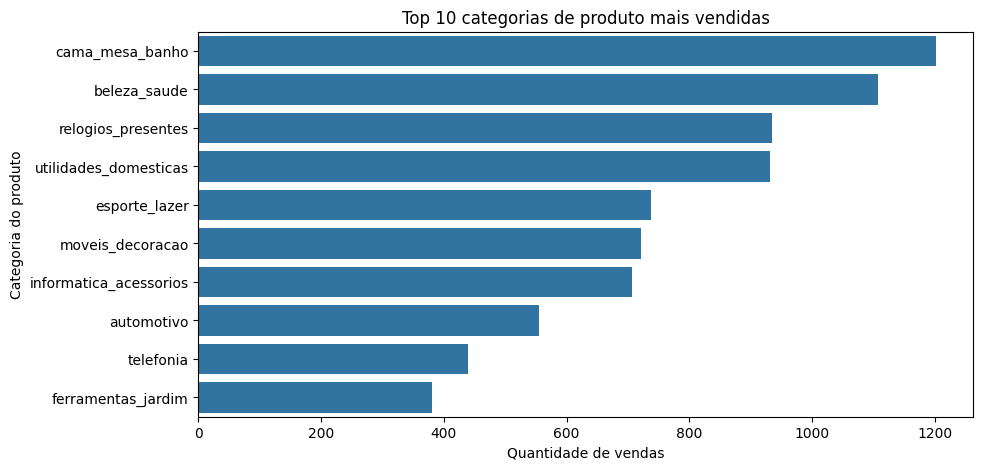

In [9]:

top_categorias = (
    df['categoria_produto']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=top_categorias.values, y=top_categorias.index)
plt.title("Top 10 categorias de produto mais vendidas")
plt.xlabel("Quantidade de vendas")
plt.ylabel("Categoria do produto")
plt.show()


### 📊 GRÁFICO 2 — Tipos de pagamento

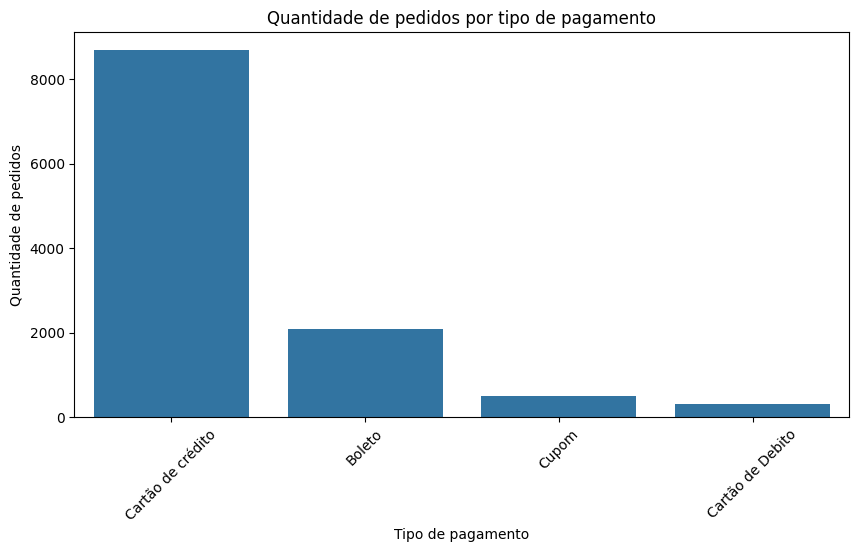

In [10]:

# Traduzir os campos
Traduzir_pagamento = {
    'credit_card': 'Cartão de crédito',
    'boleto': 'Boleto',
    'voucher': 'Cupom',
    'debit_card': 'Cartão de Debito'
}
df['tipo_pagamento'] = df['tipo_pagamento'].replace(Traduzir_pagamento)

# Contagem dos tipos de pagamento
pagamentos = (
    df['tipo_pagamento']
    .value_counts()
    .reset_index()
)
pagamentos.columns = ['tipo_pagamento', 'quantidade']

# Plot
plt.figure(figsize=(10,5))
sns.barplot(
    data=pagamentos,
    x='tipo_pagamento',
    y='quantidade'
)

plt.title("Quantidade de pedidos por tipo de pagamento")
plt.xlabel("Tipo de pagamento")
plt.ylabel("Quantidade de pedidos")
plt.xticks(rotation=45)
plt.show()

### 📊 GRÁFICO 3 — Pedidos por mês

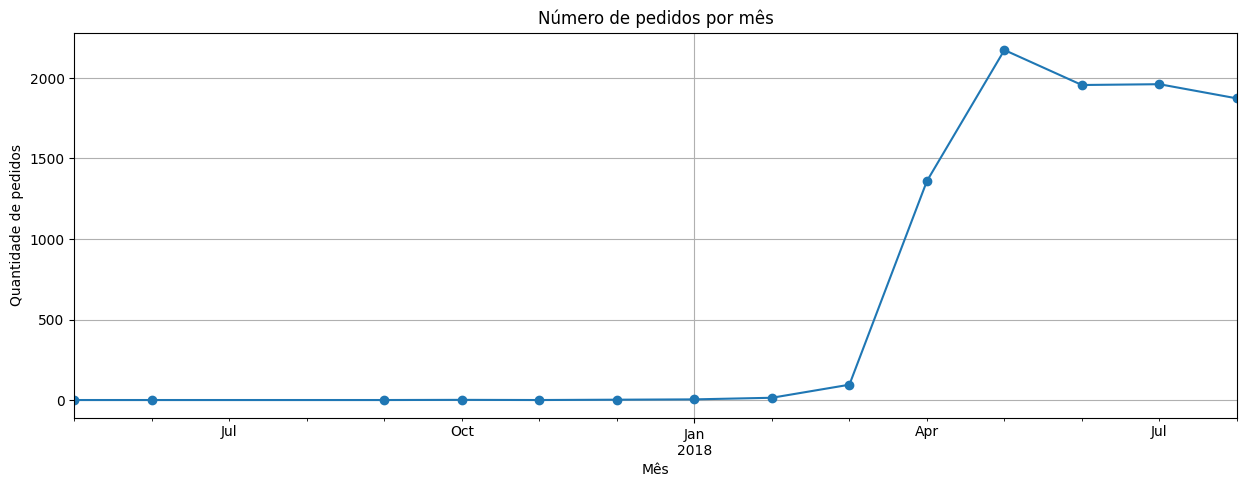

In [11]:
df['data_compra'] = pd.to_datetime(df['data_compra'], errors='coerce')
df['mes'] = df['data_compra'].dt.to_period('M')

pedidos_mes = (
    df.groupby('mes')['order_id']
    .nunique()
)

plt.figure(figsize=(15,5))
pedidos_mes.plot(kind='line', marker='o')
plt.title("Número de pedidos por mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de pedidos")
plt.grid(True)
plt.show()


### 📊 GRÁFICO 4 — Preço médio por categoria

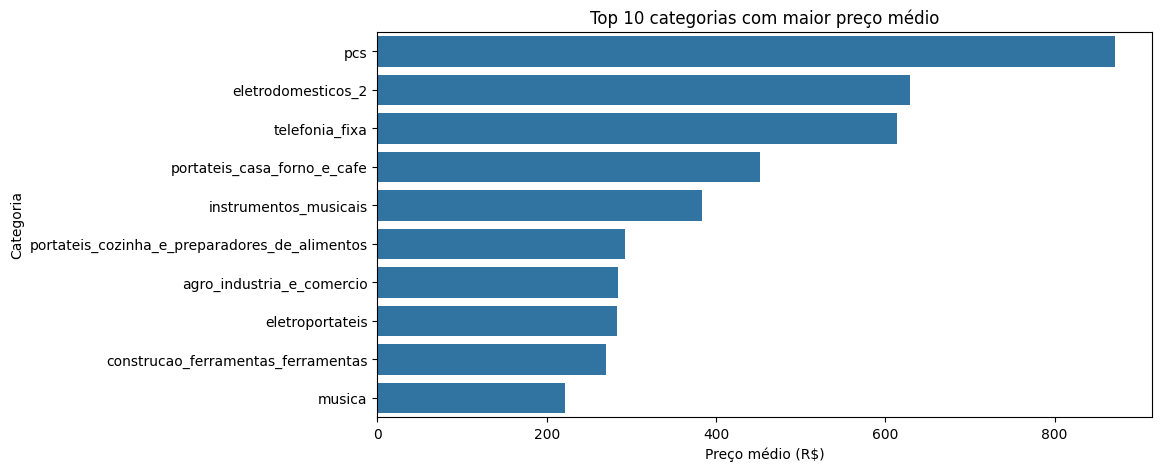

In [12]:
preco_categoria = (
    df.groupby("categoria_produto")["preco_produto"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=preco_categoria.values, y=preco_categoria.index)
plt.title("Top 10 categorias com maior preço médio")
plt.xlabel("Preço médio (R$)")
plt.ylabel("Categoria")
plt.show()


### 📊 GRÁFICO 5 — Melhores e piores avaliações

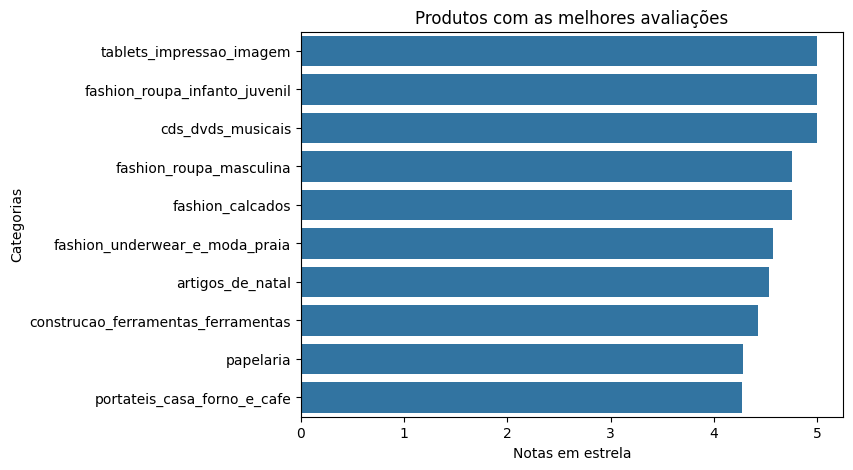

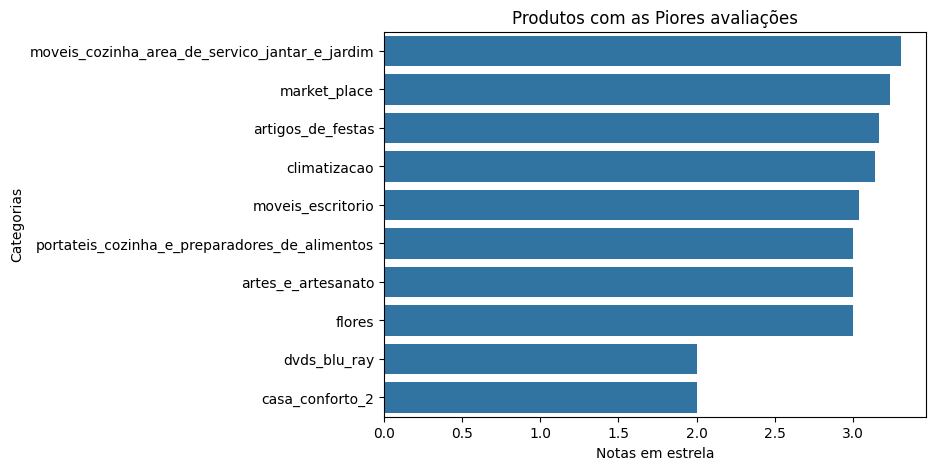

In [13]:
Avaliacao_categorias = (
    df.groupby("categoria_produto")["nota_avaliacao"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(7,5))
sns.barplot(x=Avaliacao_categorias.values, y=Avaliacao_categorias.index)
plt.title("Produtos com as melhores avaliações")
plt.xlabel("Notas em estrela")
plt.ylabel("Categorias")
plt.show()

Avaliacao_categorias = (
    df.groupby("categoria_produto")["nota_avaliacao"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
    .sort_values(ascending=False)
)
plt.figure(figsize=(7,5))
sns.barplot(x=Avaliacao_categorias.values, y=Avaliacao_categorias.index)
plt.title("Produtos com as Piores avaliações")
plt.xlabel("Notas em estrela")
plt.ylabel("Categorias")
plt.show()

### 📊 GRÁFICO 6 — Mapa do Brasil com compras por estado

In [14]:


# Agrupar quantidade de compras por estado
compras_estado = (
    df.groupby("estado_cliente")["order_id"]
    .nunique()
    .reset_index()
    .rename(columns={"order_id": "total_compras"})
)

# Arquivo GeoJSON com mapas dos estados brasileiros
# Este arquivo funciona automaticamente com UF
geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

# Criar mapa
fig = px.choropleth(
    compras_estado,
    geojson=geojson_url,
    locations="estado_cliente",      # Coluna do DF com UF
    featureidkey="properties.sigla", # Nome da propriedade dentro do GeoJSON
    color="total_compras",
    color_continuous_scale="Viridis",
    title="Total de compras por estado (Olist)",
    labels={"total_compras": "Quantidade de Compras"},
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=400)
df.to_csv("output/olist_tratada.csv", index=False, encoding="utf-8")
fig.show()
